# Incremental Training with MLJFlux

**Julia version** is assumed to be 1.10.*

### Basic Imports

In [1]:
using MLJ               # Has MLJFlux models
using Flux              # For more flexibility
import RDatasets        # Dataset source
using Plots             # For training plot

### Loading and Splitting the Data

In [2]:
iris = RDatasets.dataset("datasets", "iris");
y, X = unpack(iris, ==(:Species), colname -> true, rng=123);
X = Float32.(X);      # To be compatible with type of network network parameters

### Instantiating the model
Now let's construct our model. This follows a similar setup to the one followed in the [Quick Start](../../index.md).

In [3]:
NeuralNetworkClassifier = @load NeuralNetworkClassifier pkg=MLJFlux

clf = NeuralNetworkClassifier(
    builder=MLJFlux.MLP(; hidden=(5,4), σ=Flux.relu),
    optimiser=Flux.ADAM(0.01),
    batch_size=8,
    epochs=50,
    rng=42
    )

[ Info: For silent loading, specify `verbosity=0`. 
import MLJFlux ✔


NeuralNetworkClassifier(
  builder = MLP(
        hidden = (5, 4), 
        σ = NNlib.relu), 
  finaliser = NNlib.softmax, 
  optimiser = Adam(0.01, (0.9, 0.999), 1.0e-8, IdDict{Any, Any}()), 
  loss = Flux.Losses.crossentropy, 
  epochs = 50, 
  batch_size = 8, 
  lambda = 0.0, 
  alpha = 0.0, 
  rng = 42, 
  optimiser_changes_trigger_retraining = false, 
  acceleration = CPU1{Nothing}(nothing))

Now let's wrap this in an iterated model. We will use a callback that makes a plot for validation losses each iteration.

In [4]:
stop_conditions = [
    Step(1),            # Repeatedly train for one iteration
    NumberLimit(100),   # Don't train for more than 100 iterations
]

validation_losses =  []
gr(reuse=true)                  # use the same window for plots
function plot_loss(loss)
    push!(validation_losses, loss)
    display(plot(validation_losses, label="validation loss", xlim=(1, 100)))
   sleep(.01)                   # to catch up with the plots while they are being generated
end

callbacks = [ WithLossDo(plot_loss),]

iterated_model = IteratedModel(model=clf,
                               resampling=Holdout(),    # Split the data internally into 0.7 training and 0.3 validation
                               measures=log_loss,
                               iteration_parameter=:(epochs),
                               controls=vcat(stop_conditions, callbacks),
                               retrain=true                  # no need to retrain on all data at the end
                               )

ProbabilisticIteratedModel(
  model = NeuralNetworkClassifier(
        builder = MLP(hidden = (5, 4), …), 
        finaliser = NNlib.softmax, 
        optimiser = Adam(0.01, (0.9, 0.999), 1.0e-8, IdDict{Any, Any}()), 
        loss = Flux.Losses.crossentropy, 
        epochs = 50, 
        batch_size = 8, 
        lambda = 0.0, 
        alpha = 0.0, 
        rng = 42, 
        optimiser_changes_trigger_retraining = false, 
        acceleration = CPU1{Nothing}(nothing)), 
  controls = Any[Step(1), NumberLimit(100), WithLossDo{typeof(Main.var"##365".plot_loss)}(Main.var"##365".plot_loss, false, nothing)], 
  resampling = Holdout(
        fraction_train = 0.7, 
        shuffle = false, 
        rng = Random._GLOBAL_RNG()), 
  measure = LogLoss(tol = 2.22045e-16), 
  weights = nothing, 
  class_weights = nothing, 
  operation = nothing, 
  retrain = true, 
  check_measure = true, 
  iteration_parameter = :epochs, 
  cache = true)

### Live Training
Simply fitting the model is all we need

[ Info: Training machine(ProbabilisticIteratedModel(model = NeuralNetworkClassifier(builder = MLP(hidden = (5, 4), …), …), …), …).
[ Info: final loss: 0.11905657006943889
[ Info: final training loss: 0.07196077
[ Info: Stop triggered by NumberLimit(100) stopping criterion. 
[ Info: Retraining on all provided data. To suppress, specify `retrain=false`. 
[ Info: Total of 100 iterations. 


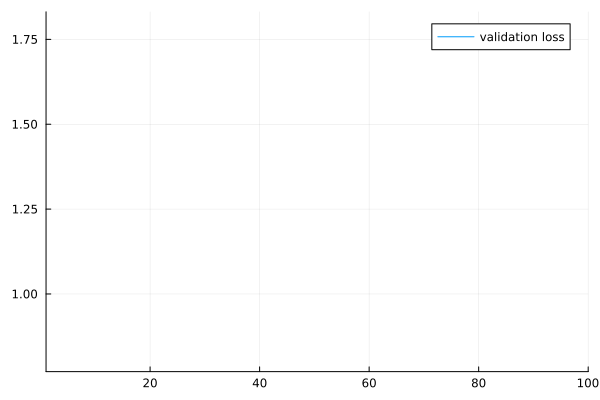

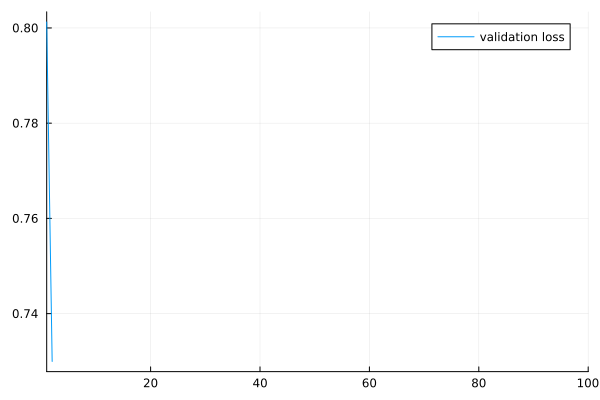

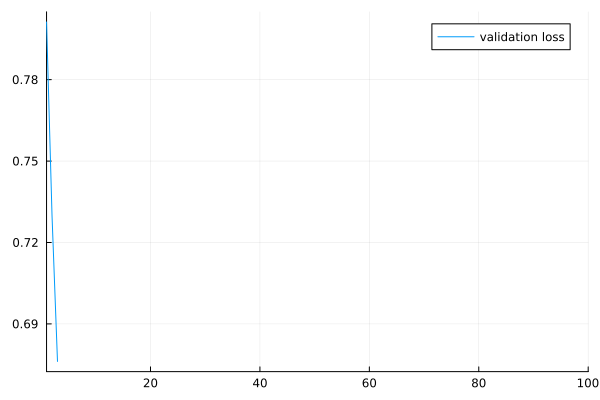

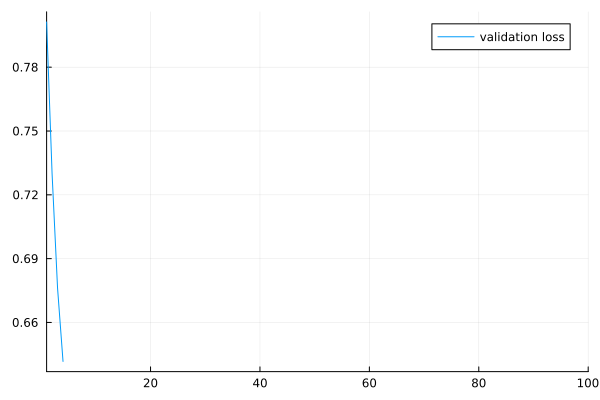

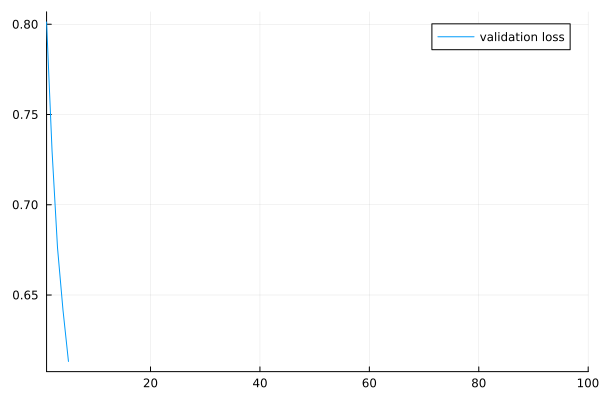

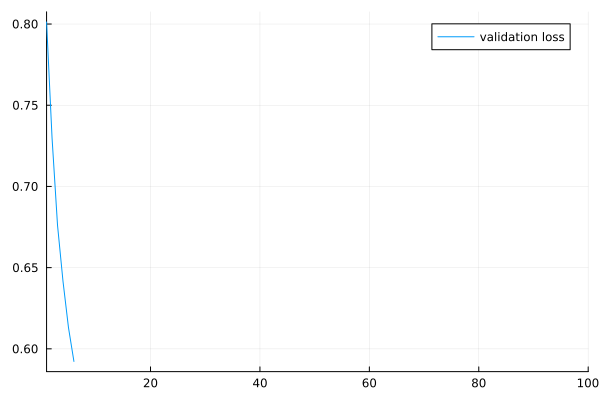

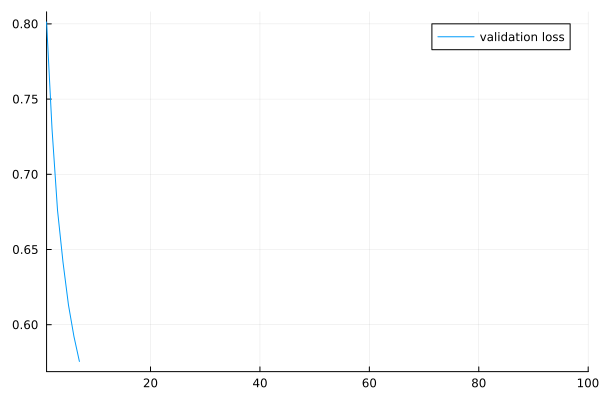

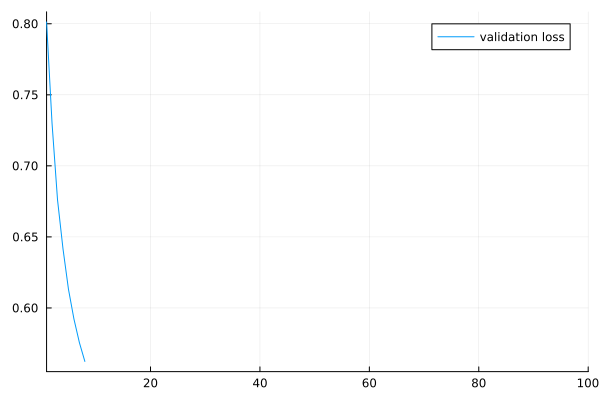

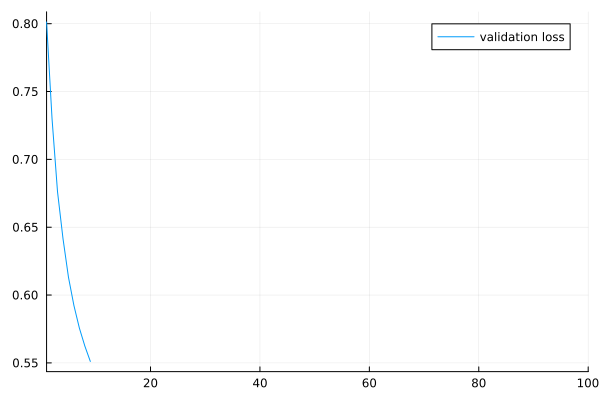

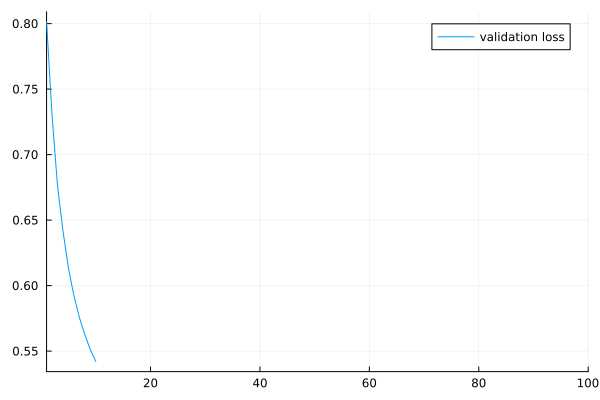

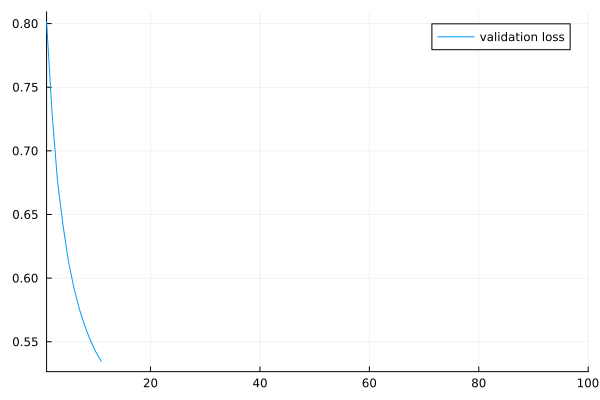

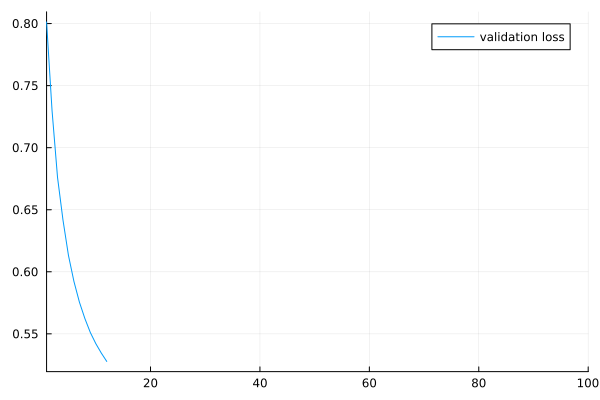

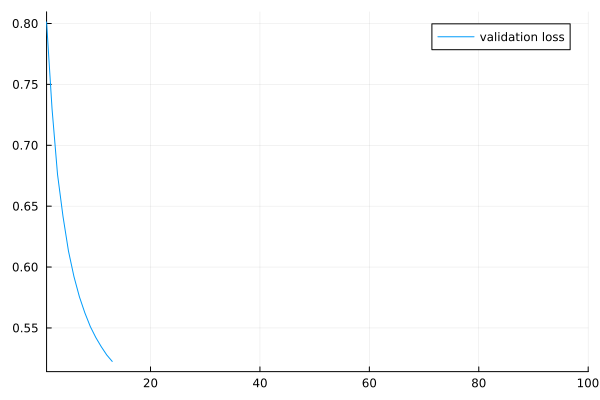

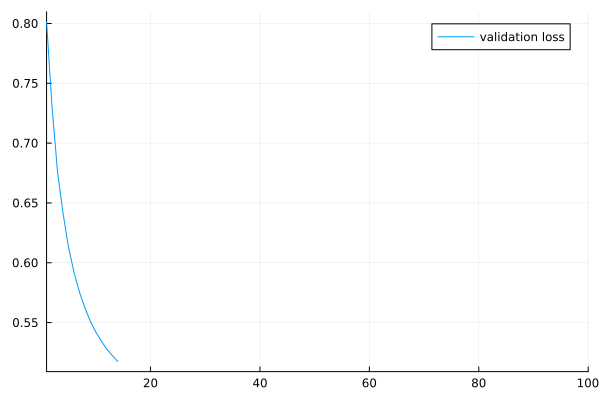

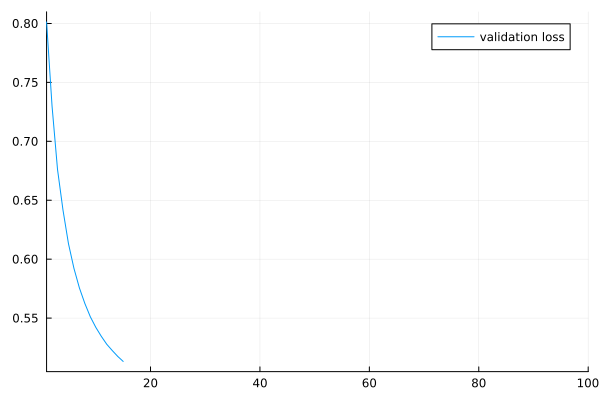

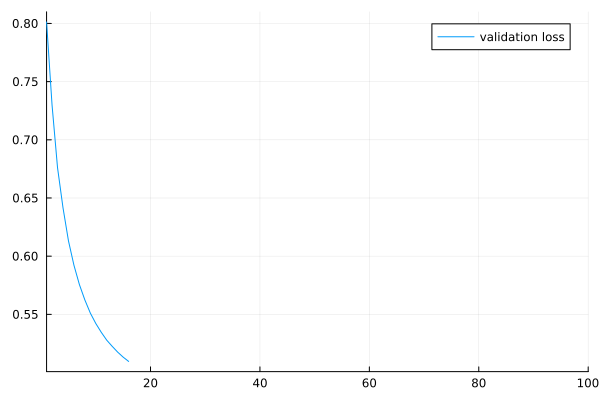

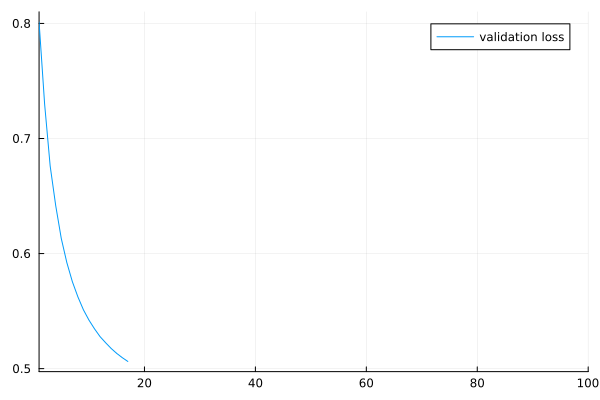

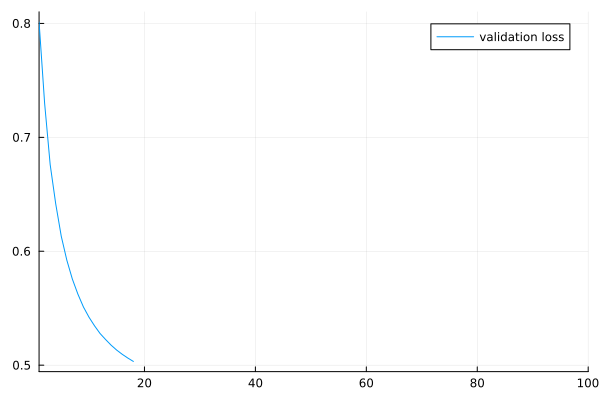

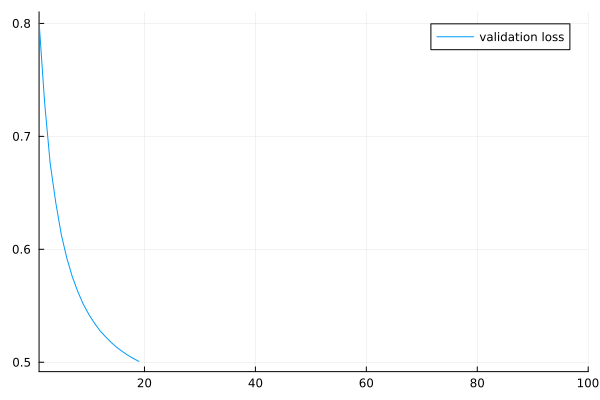

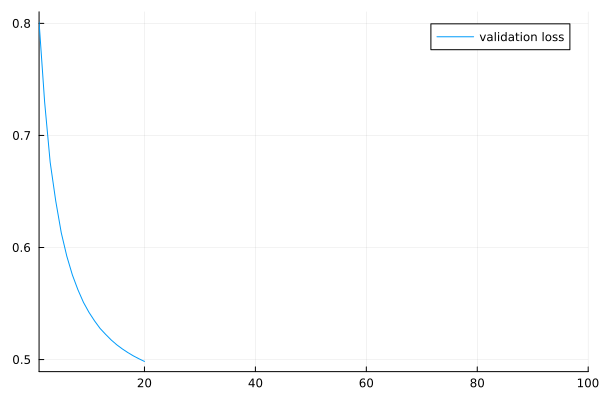

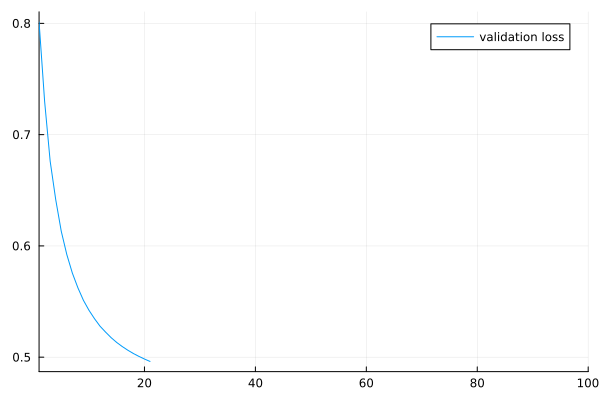

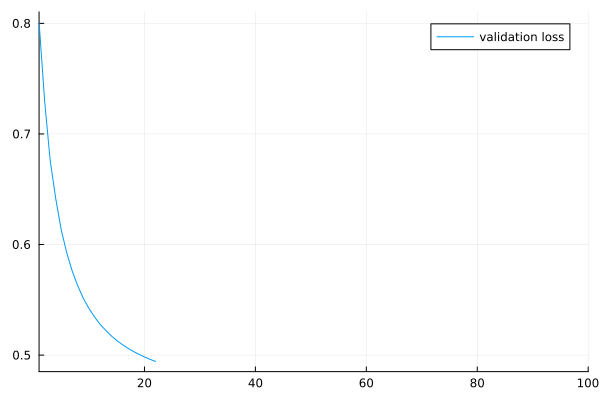

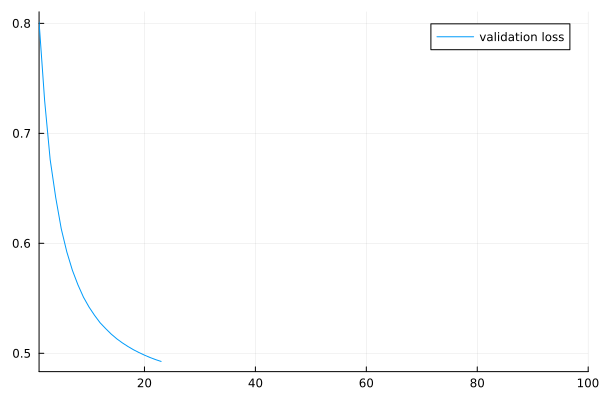

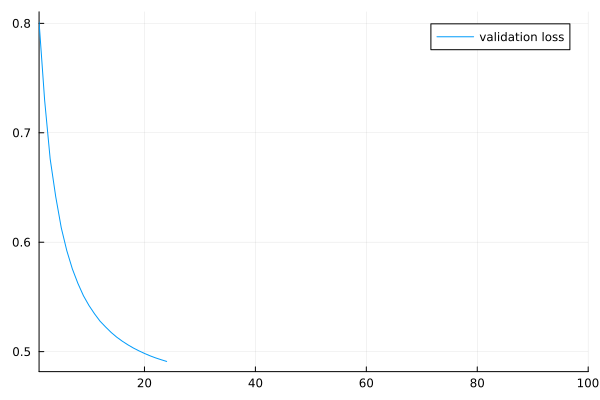

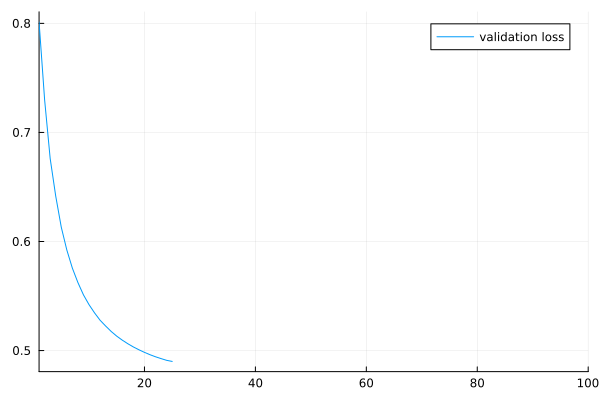

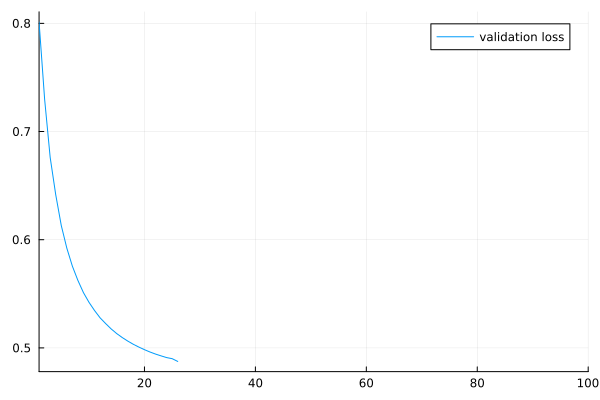

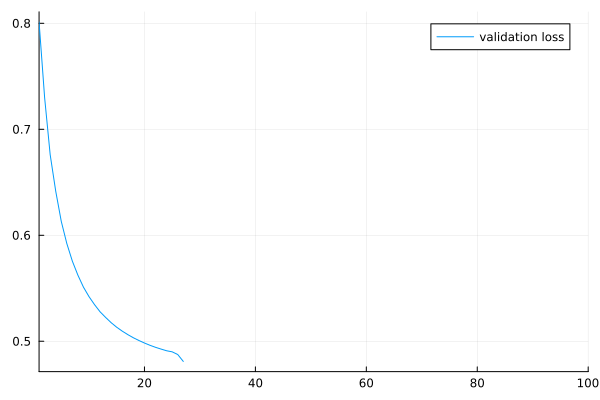

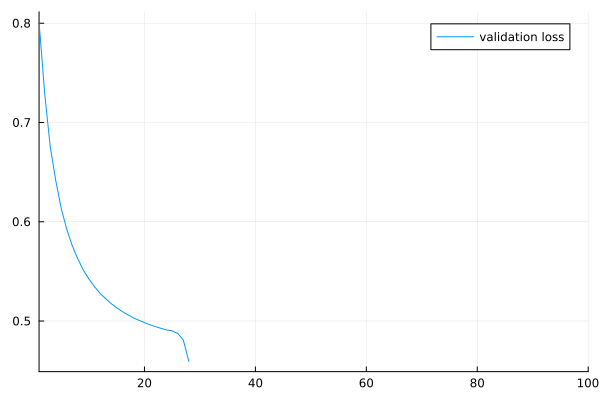

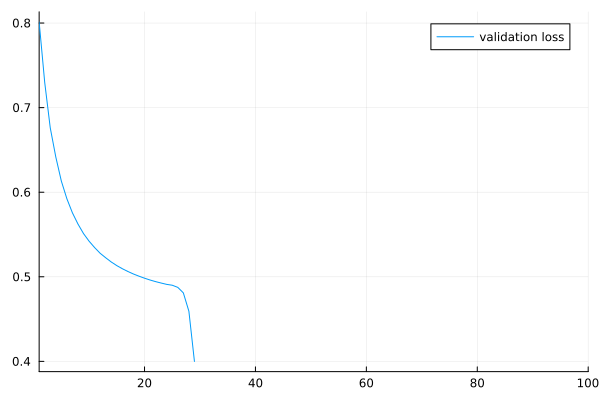

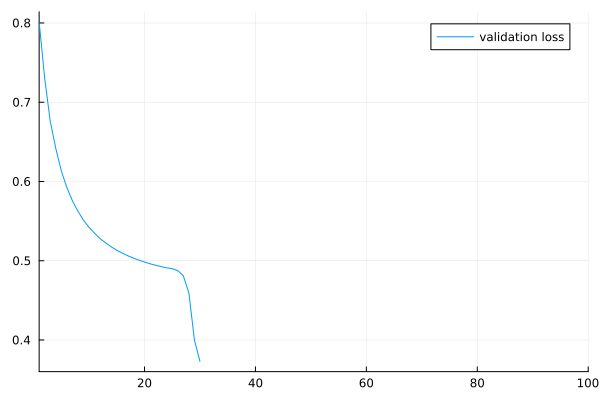

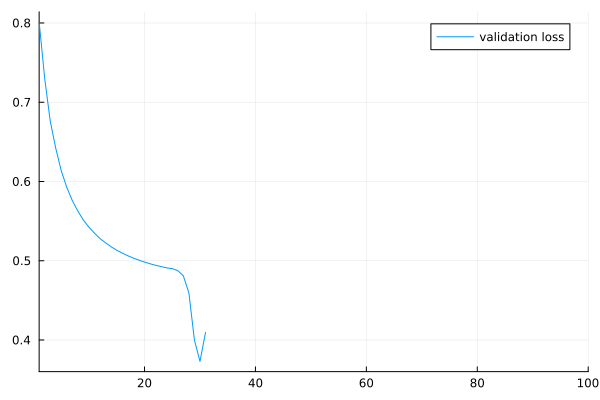

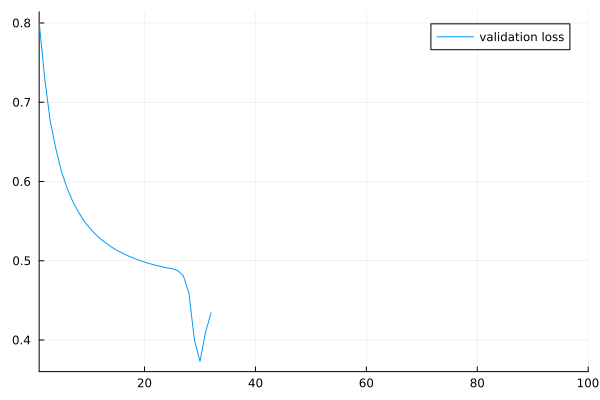

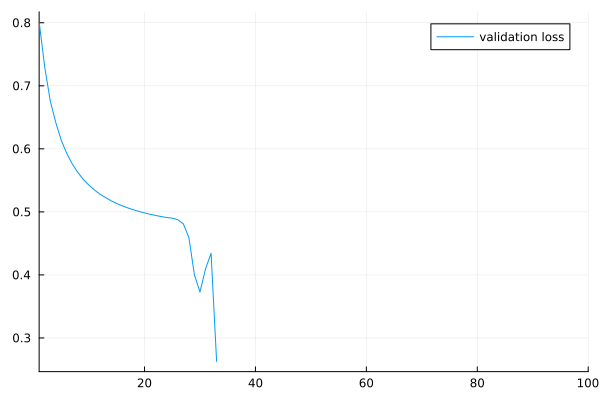

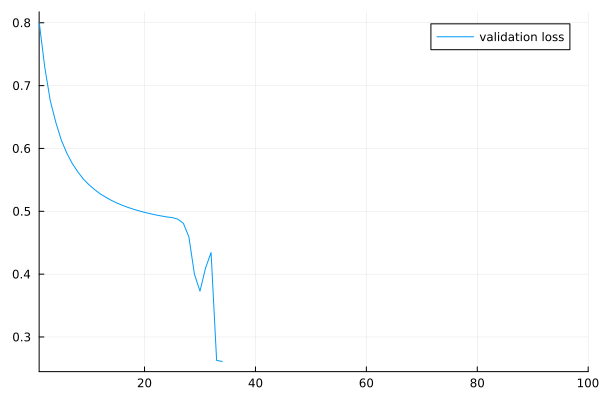

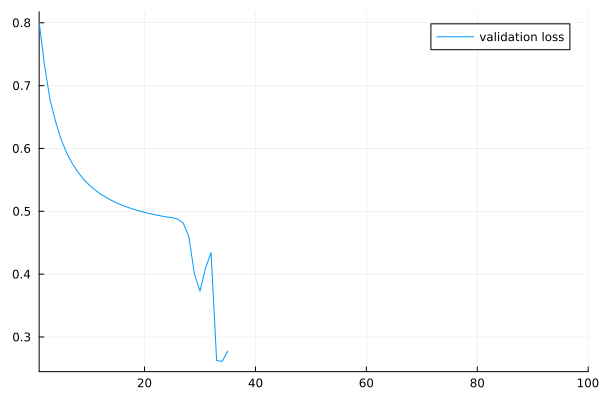

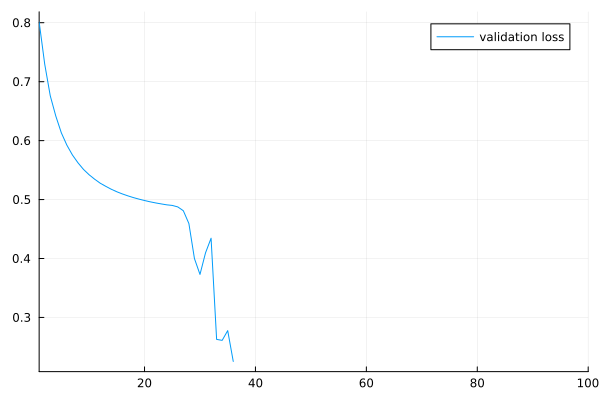

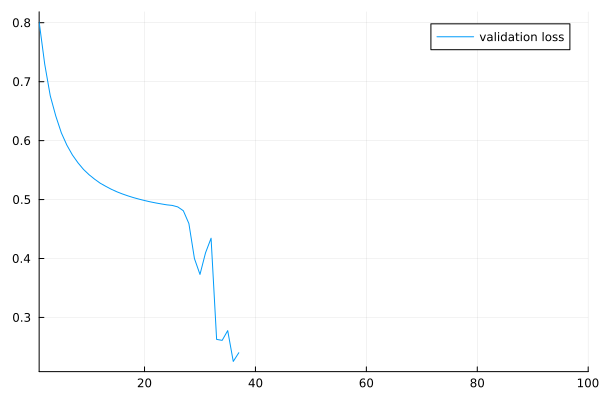

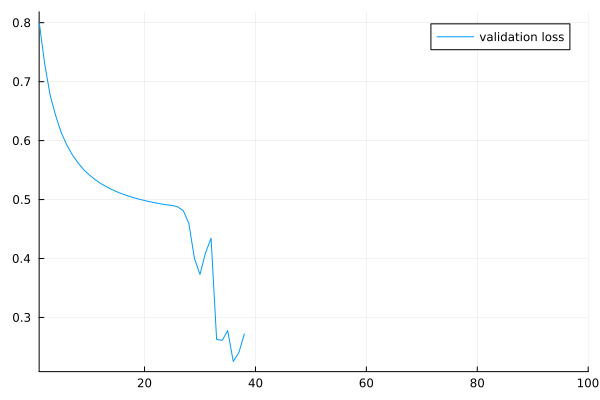

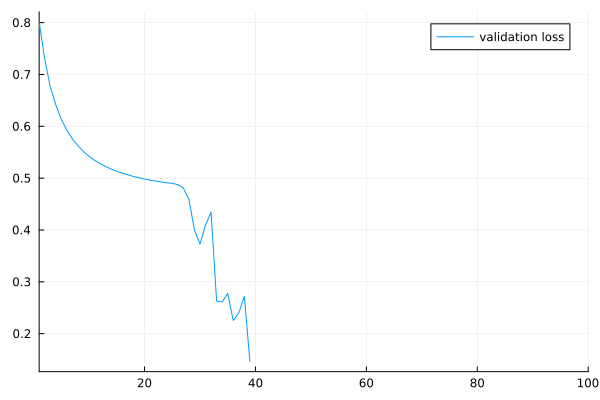

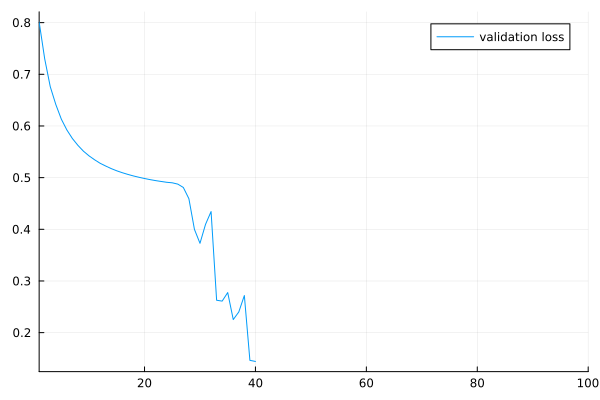

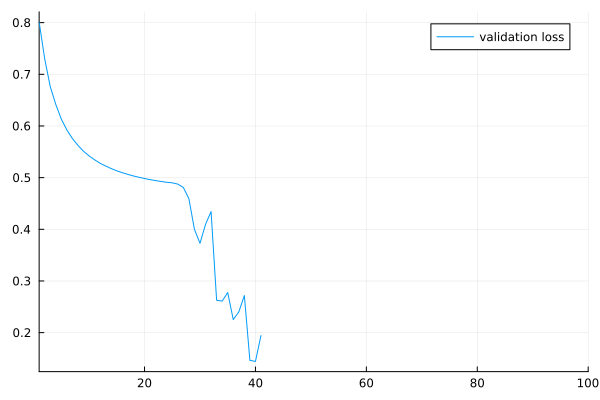

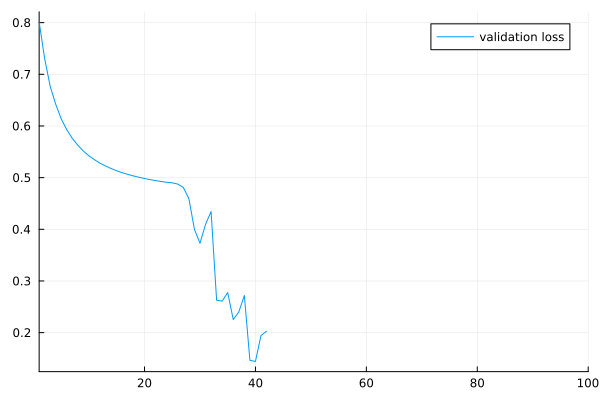

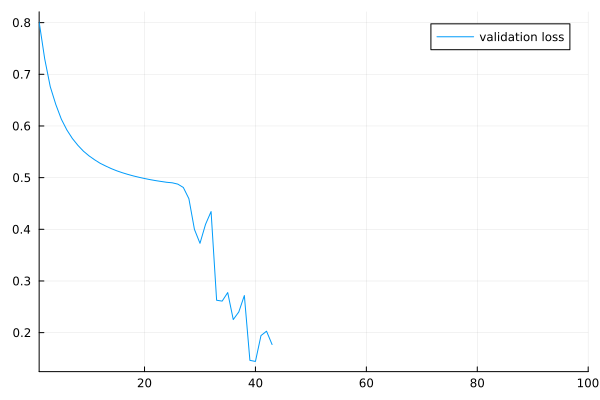

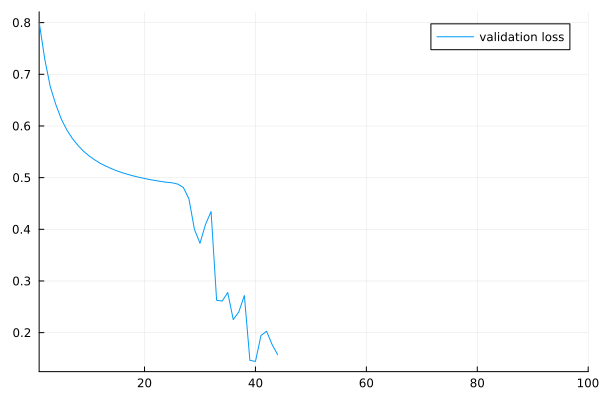

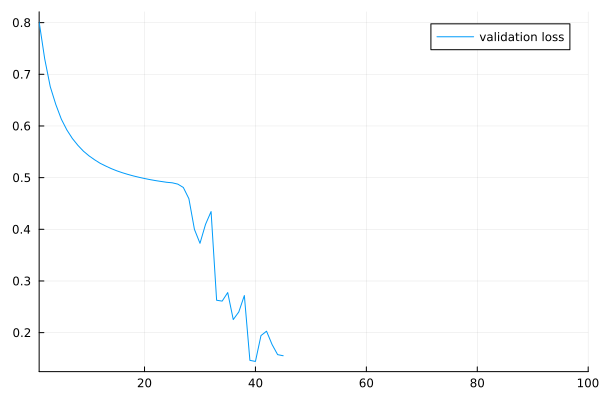

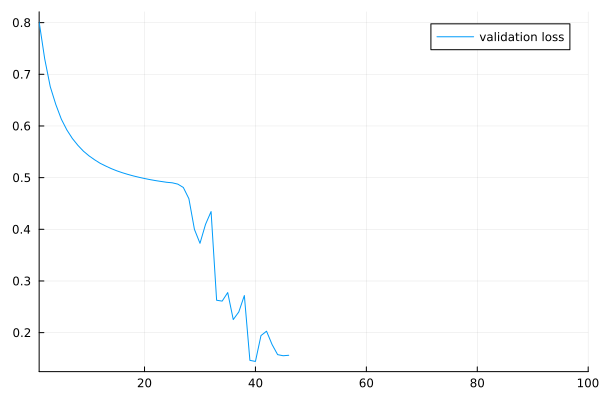

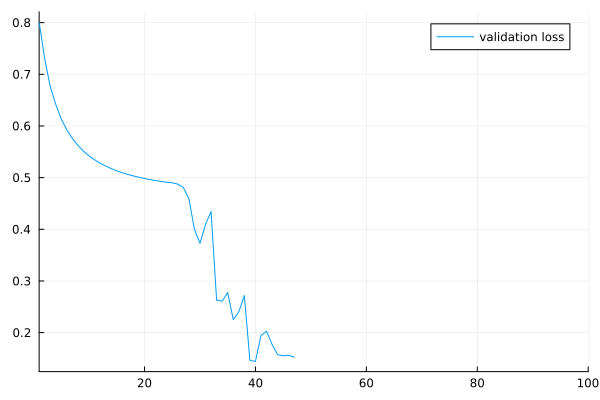

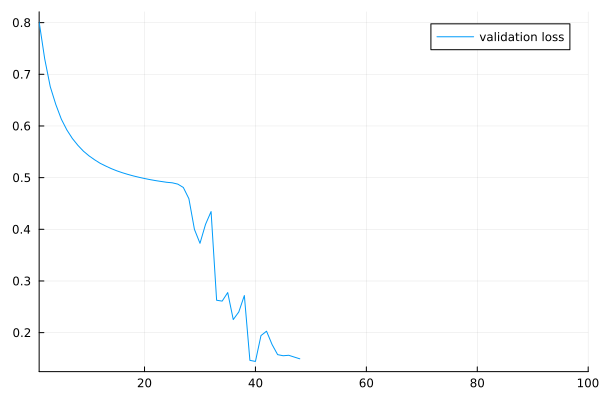

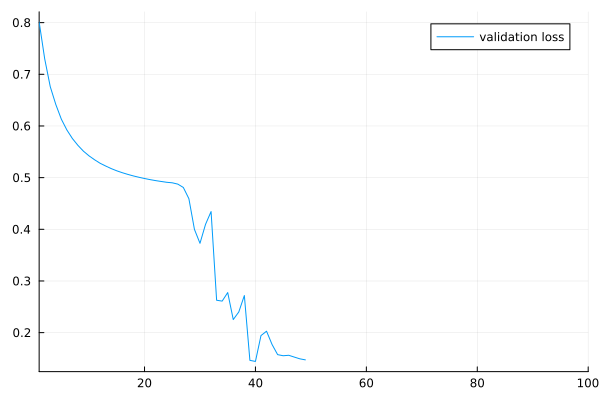

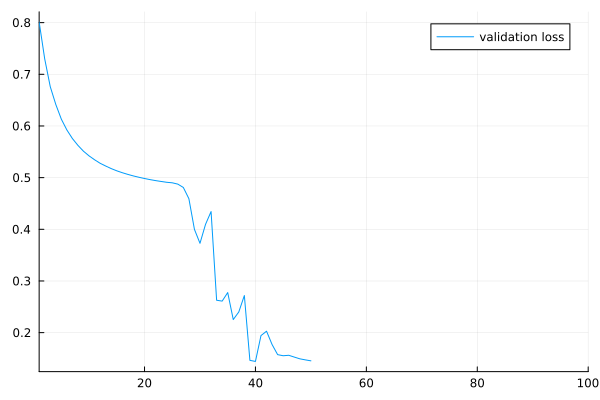

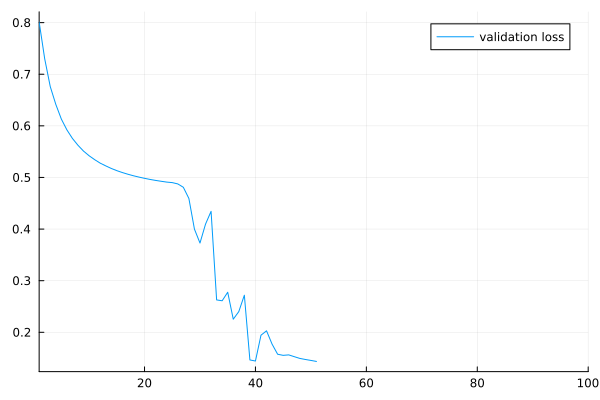

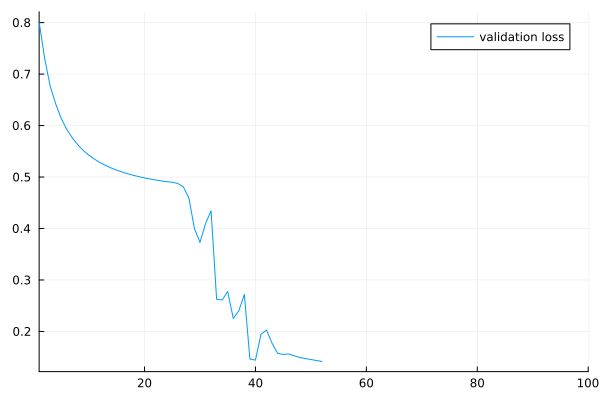

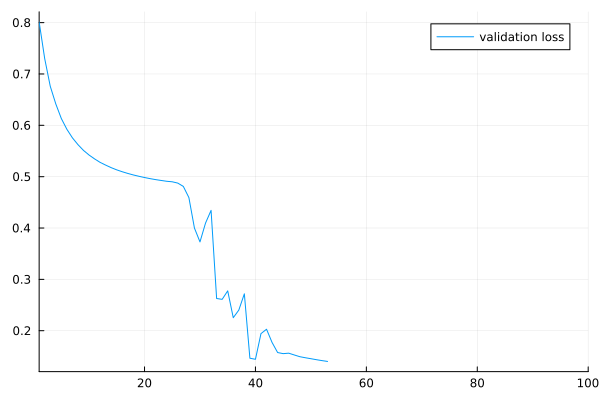

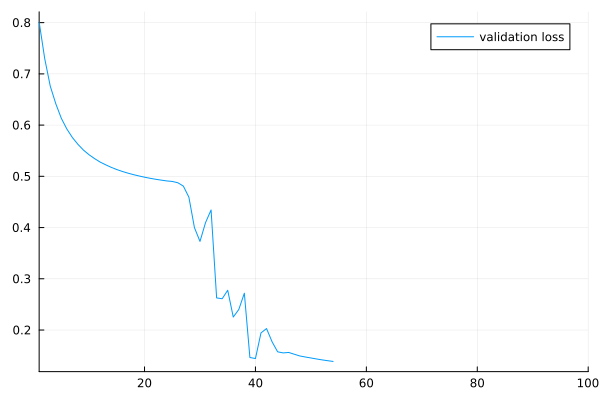

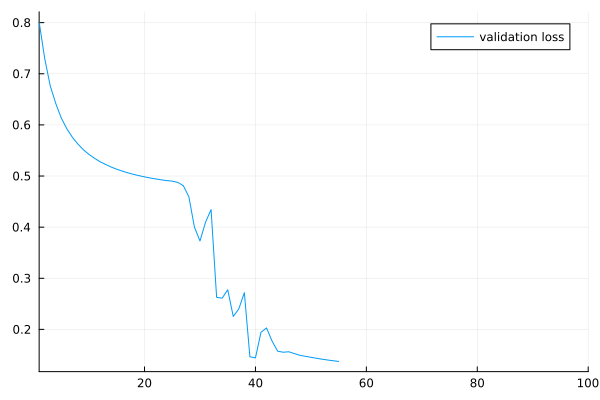

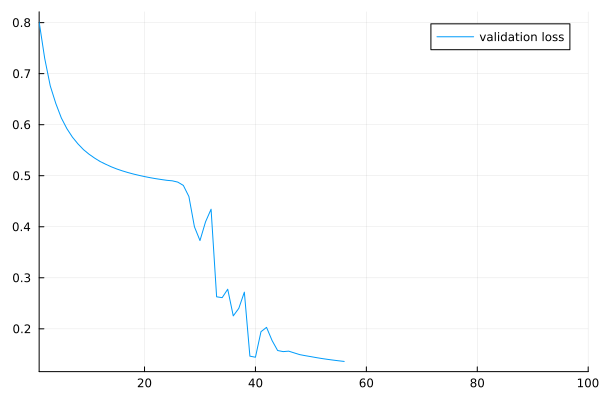

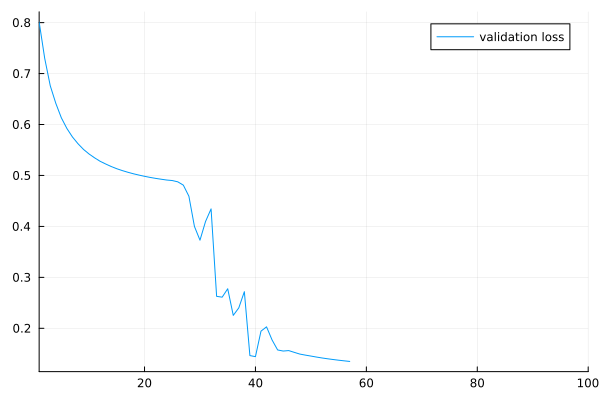

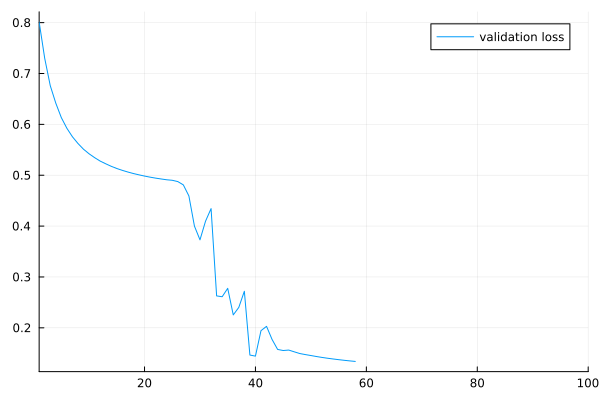

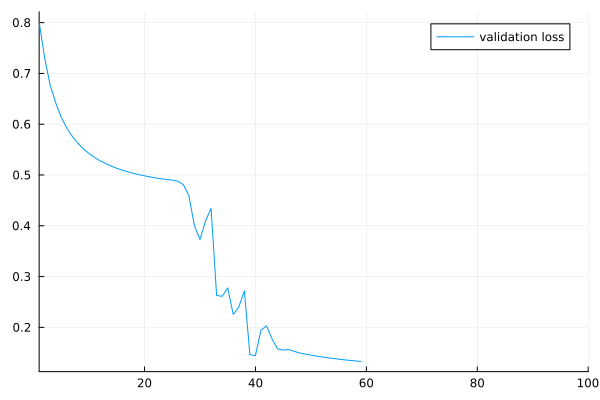

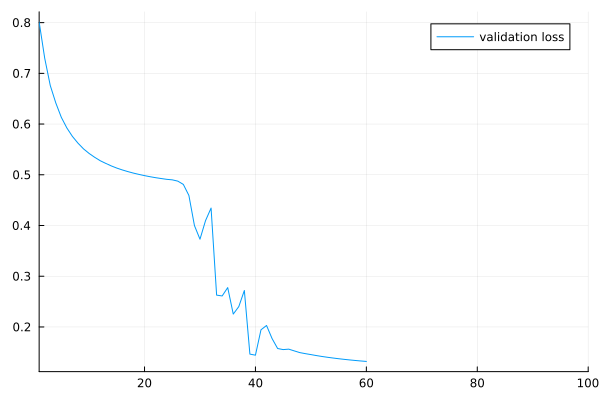

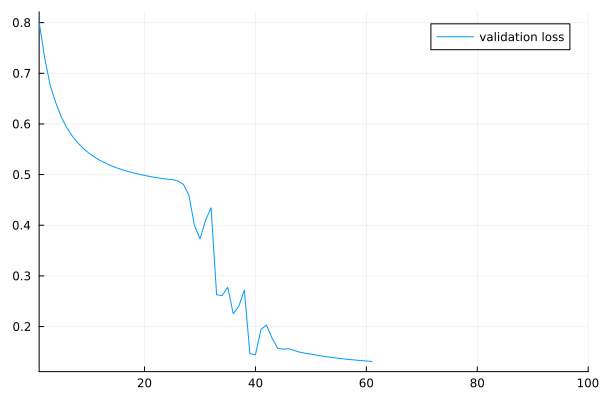

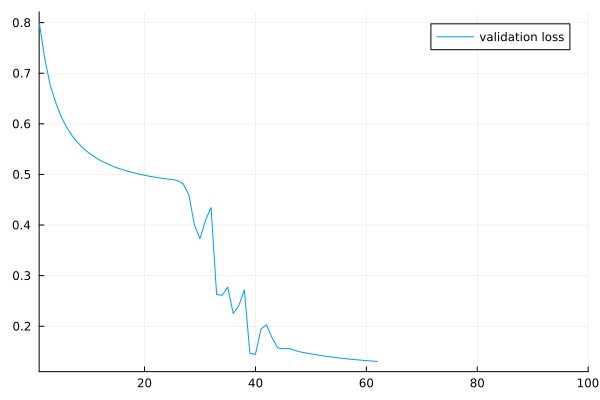

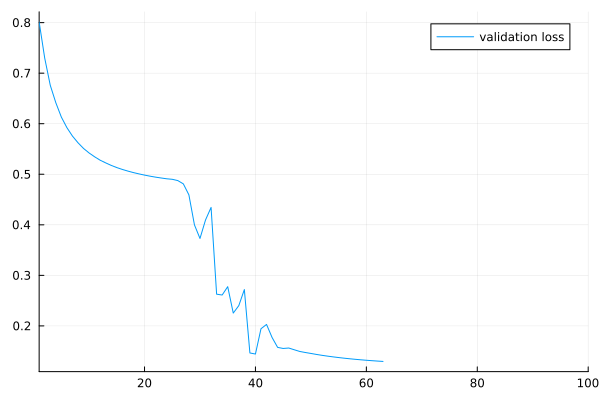

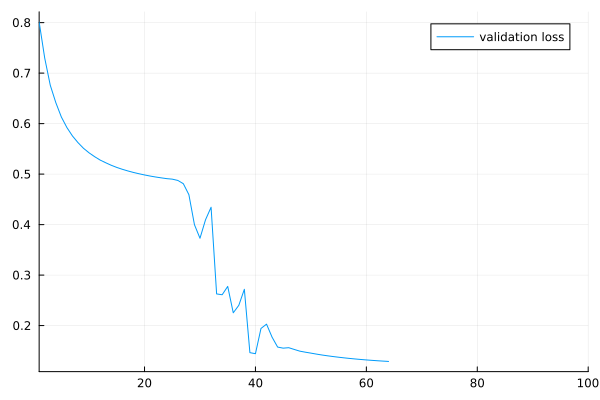

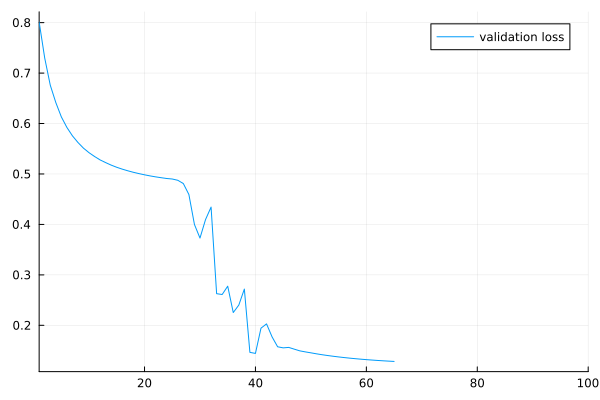

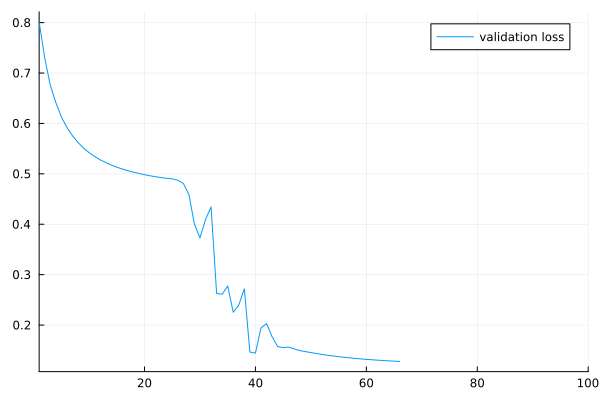

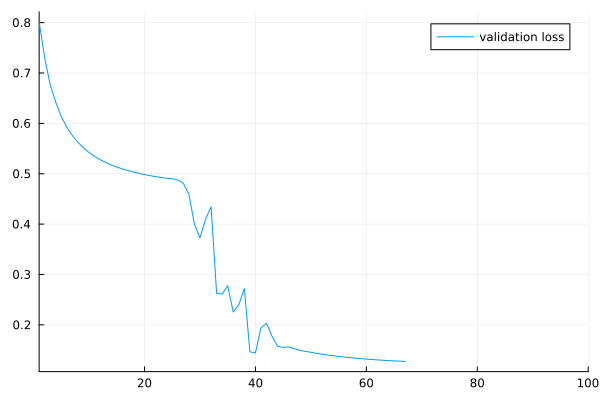

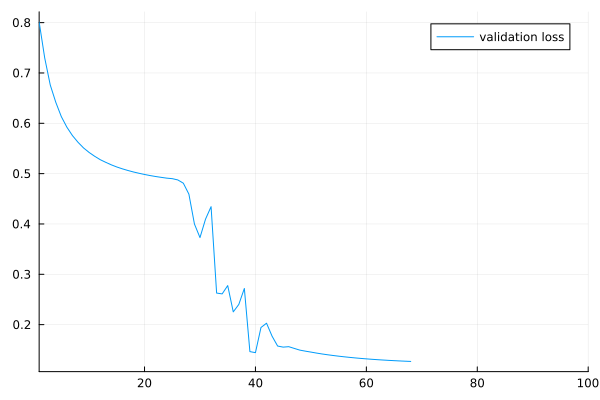

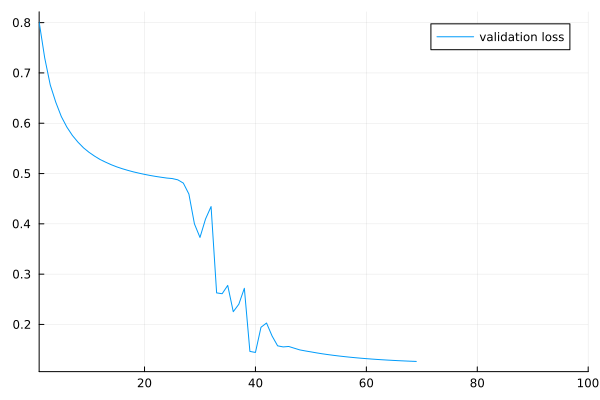

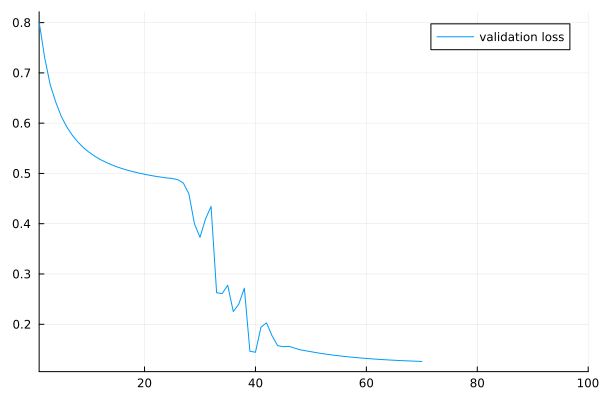

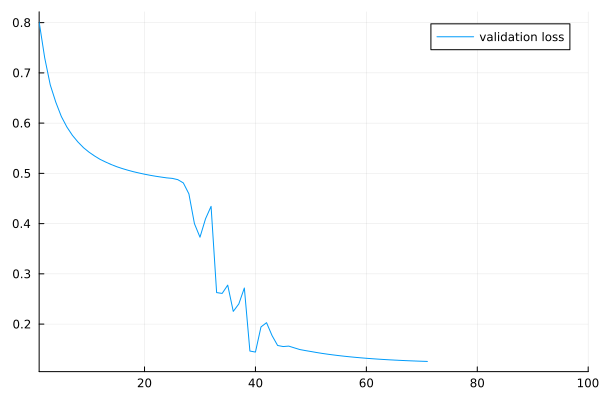

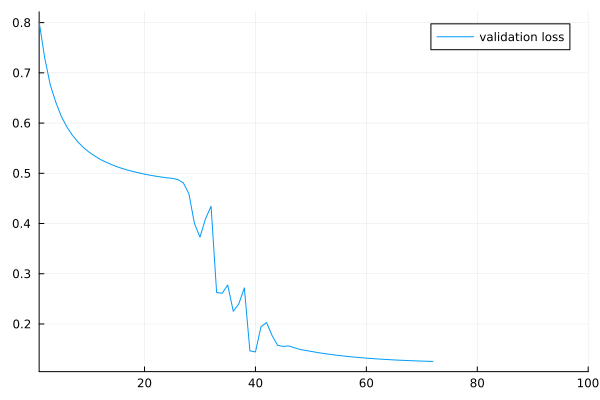

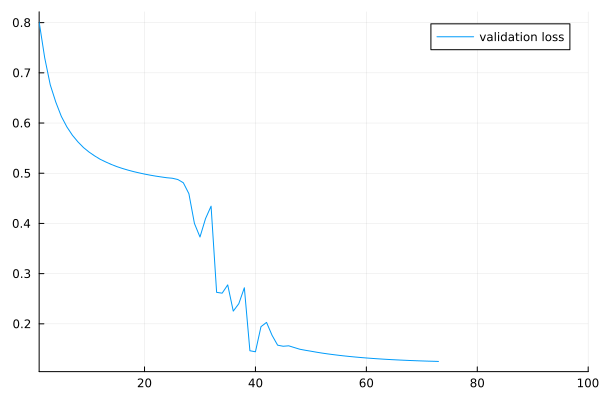

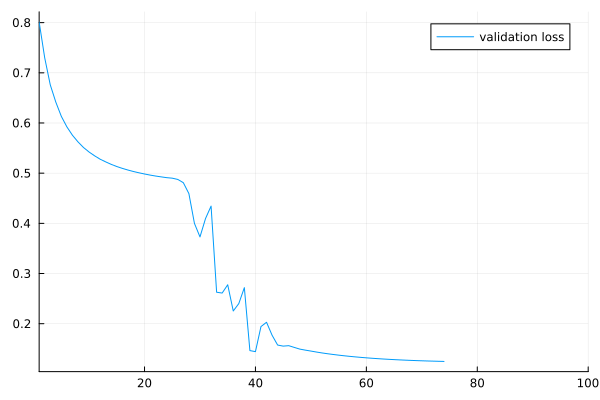

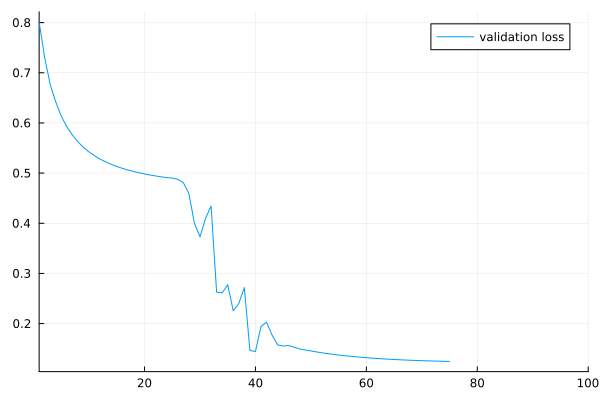

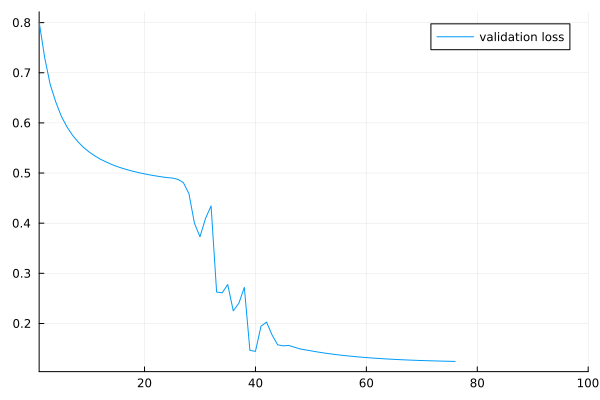

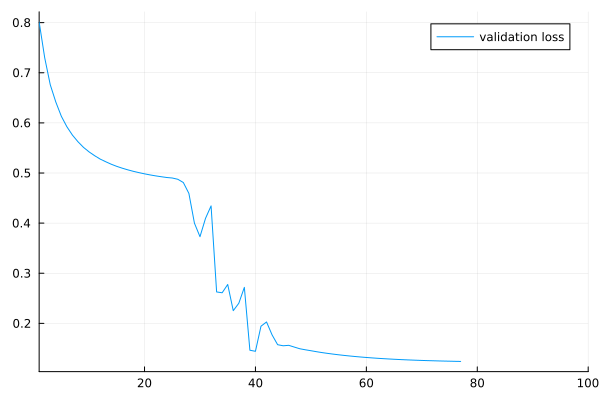

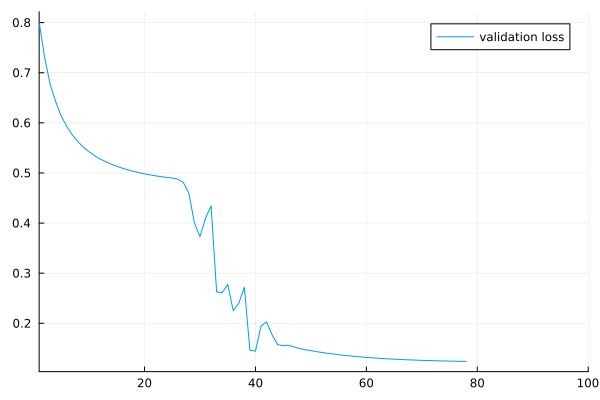

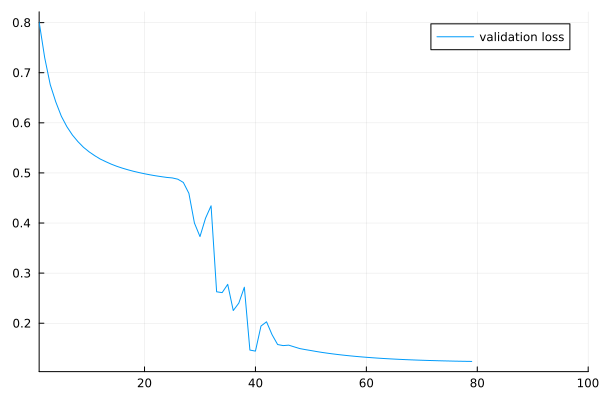

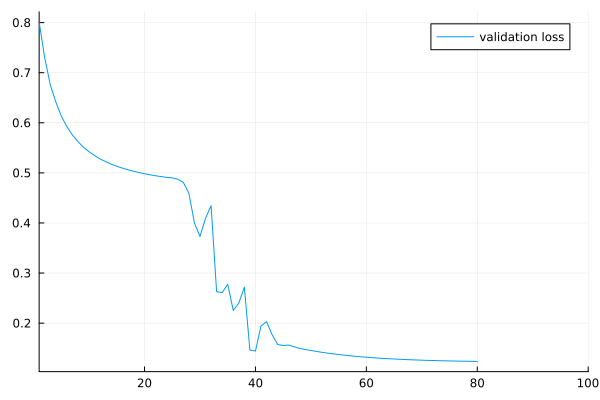

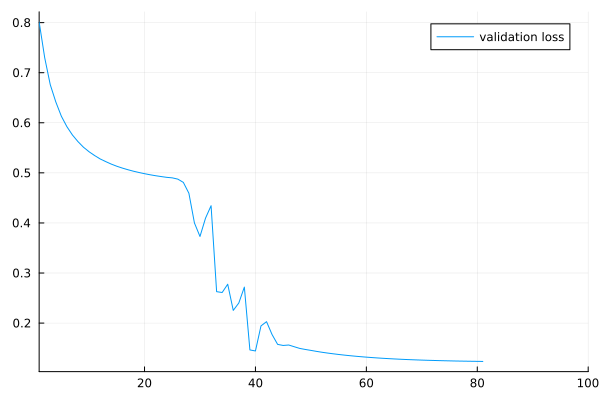

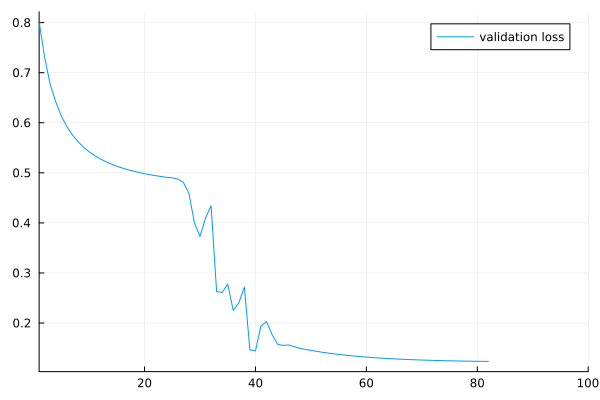

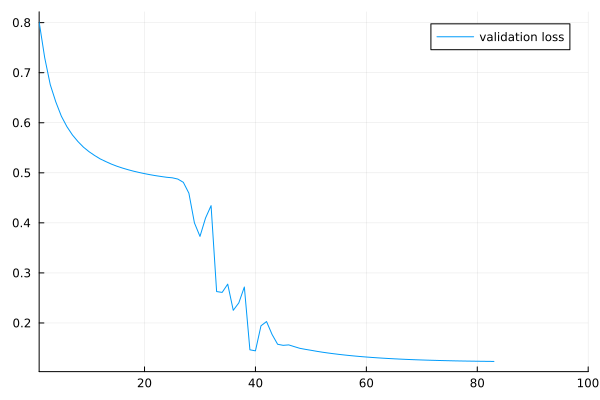

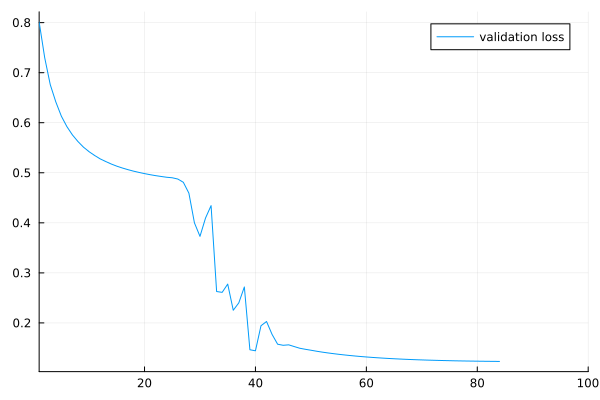

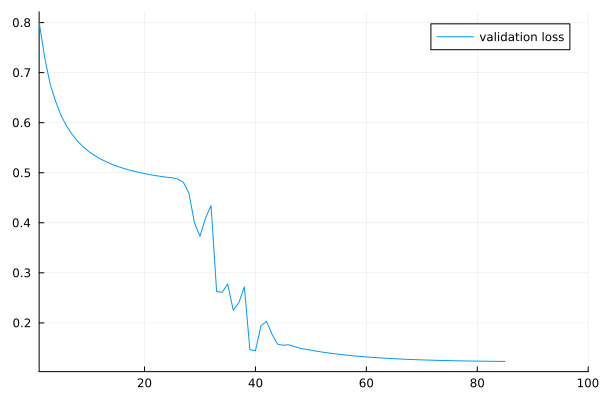

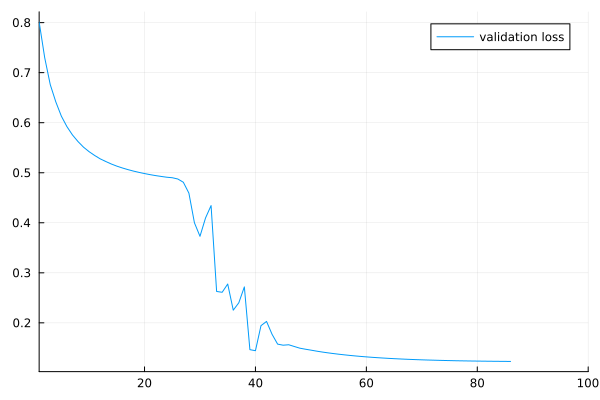

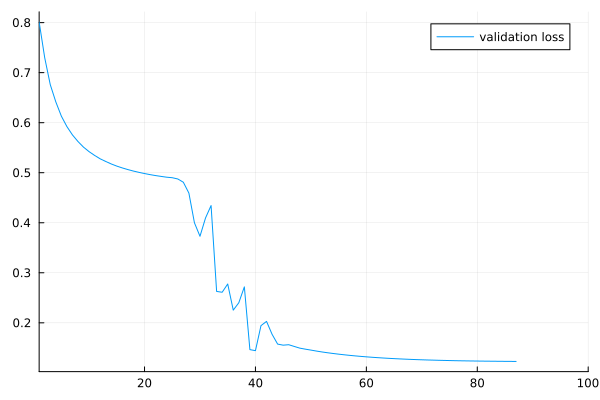

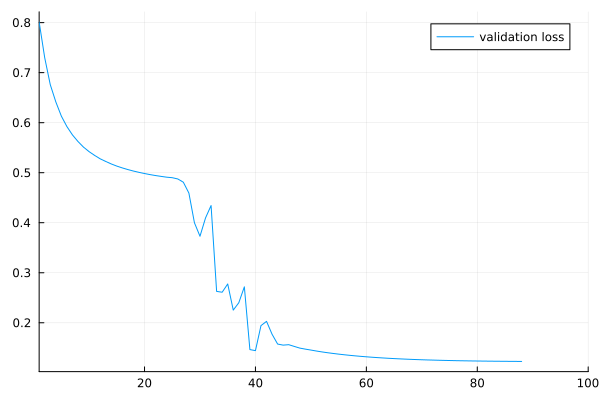

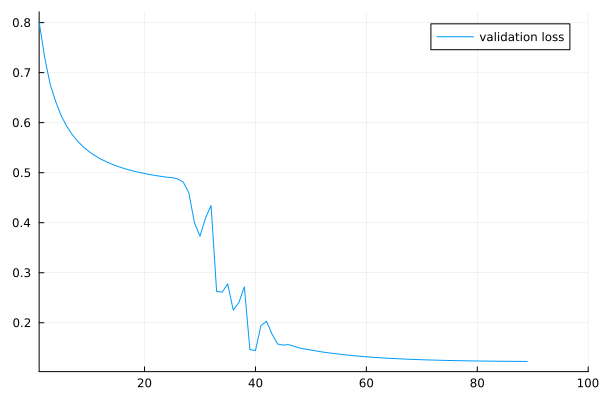

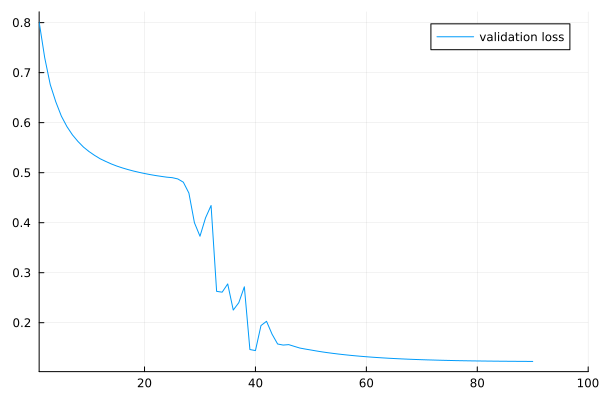

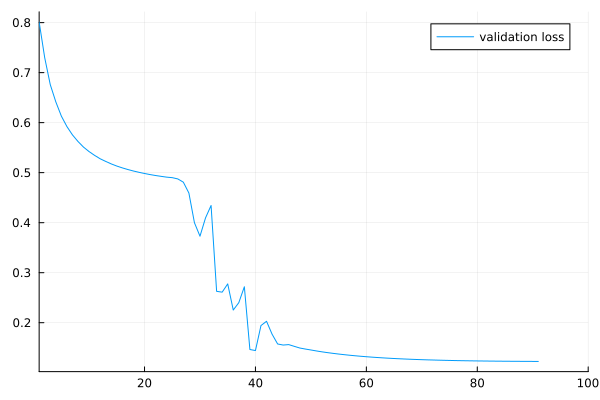

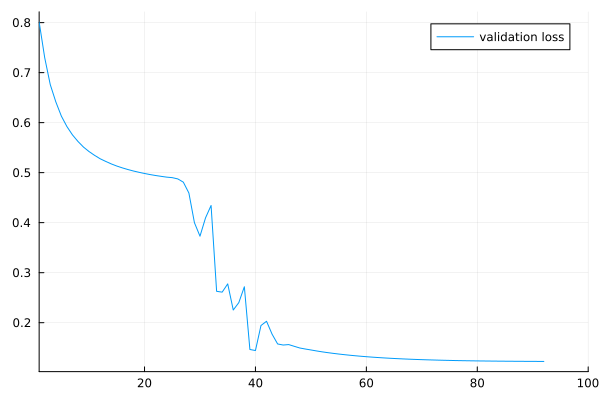

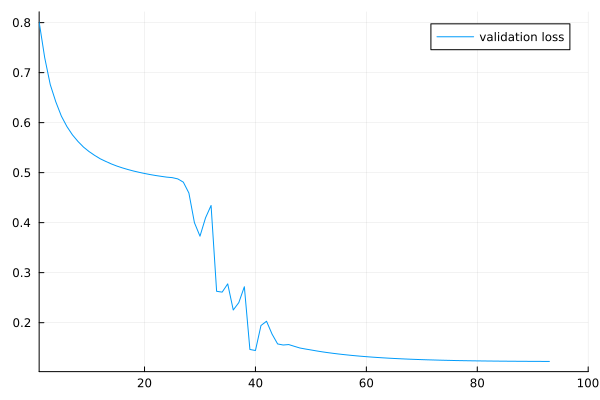

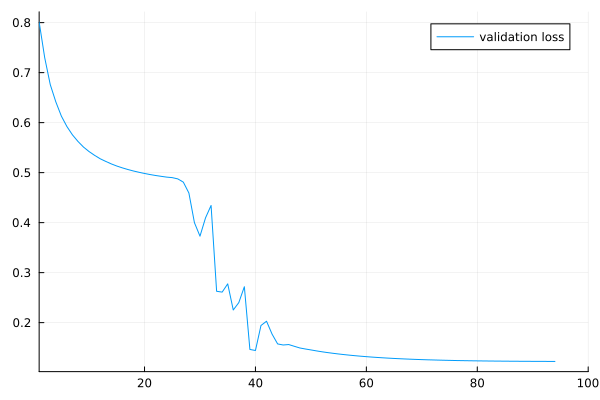

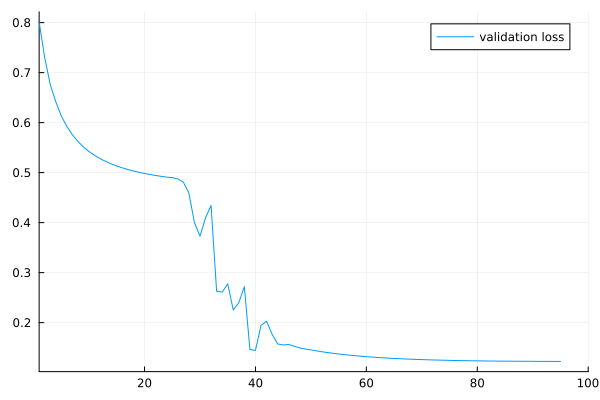

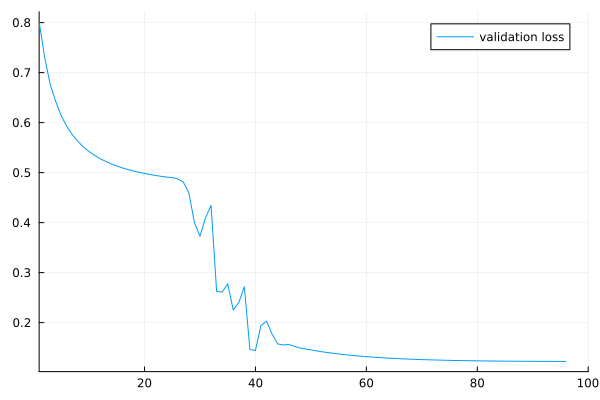

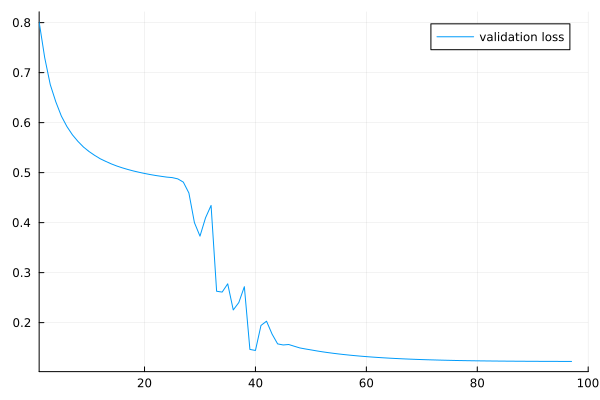

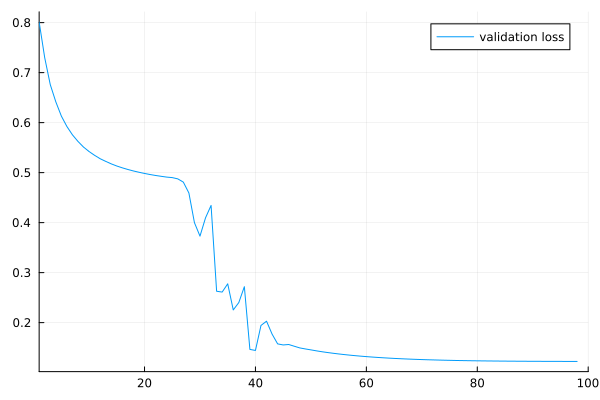

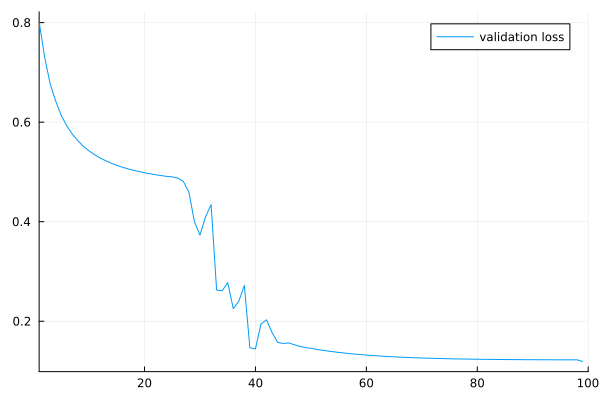

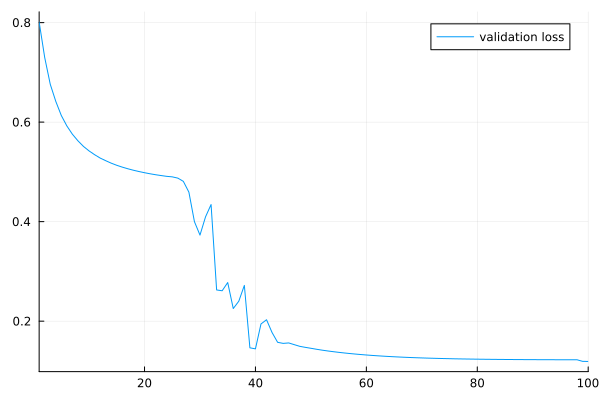

trained Machine; does not cache data
  model: ProbabilisticIteratedModel(model = NeuralNetworkClassifier(builder = MLP(hidden = (5, 4), …), …), …)
  args: 
    1:	Source @012 ⏎ Table{AbstractVector{Continuous}}
    2:	Source @753 ⏎ AbstractVector{Multiclass{3}}


In [5]:
mach = machine(iterated_model, X, y)
fit!(mach, force=true)

In [6]:
using Literate #src

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*